In [1]:

# Importing Required Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning Libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc
from sklearn.decomposition import PCA

# KAN Libraries
from kan import KAN
import torch

In [2]:

# Step 2: Load and clean the dataset
df = pd.read_csv('DataCoSupplyChainDataset.csv', header=0, encoding='unicode_escape')

df.head()


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [7]:

# Combining the Last Name and First names to identify unique customers
df['Cust_Full_Name'] = df['Customer Fname'].astype(str) + ' ' + df['Customer Lname'].astype(str)

# Dropping unimporant columns
df.drop(['Customer Email', 'Product Status', 'Customer Password', 'Customer Street', 'Customer Fname',
         'Customer Lname', 'Latitude', 'Longitude', 'Product Description', 'Product Image', 'Order Zipcode',
         'shipping date (DateOrders)'], axis=1, inplace=True)

# Dropping rows with missing values
df = df.dropna()

# Creating new columns from the Order Date Column
df['order_yr'] = pd.DatetimeIndex(df['order date (DateOrders)']).year
df['order_month'] = pd.DatetimeIndex(df['order date (DateOrders)']).month
df['order_day'] = pd.DatetimeIndex(df['order date (DateOrders)']).weekday
df['order_hour'] = pd.DatetimeIndex(df['order date (DateOrders)']).hour

# Dropping additional columns that are less relevant
columns_to_drop = ['Customer Email', 'Customer Fname', 'Customer Lname', 'Customer Password',
                   'Customer Street', 'Customer Zipcode', 'Product Description', 'Product Image',
                   'shipping date (DateOrders)', 'order date (DateOrders)', 'Order Zipcode']
df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')

# Converting object type columns to categorical if they are not dates
for col in df_cleaned.select_dtypes(include=['object']).columns:
    if col not in ['shipping date (DateOrders)', 'order date (DateOrders)']:
        df_cleaned[col] = df_cleaned[col].astype('category')

# Applying label encoding to categorical columns
label_encoder = LabelEncoder()
for col in df_cleaned.select_dtypes(include=['category']).columns:
    df_cleaned[col] = label_encoder.fit_transform(df_cleaned[col])

# Step 3: Preparing Data for KAN model
train_df = df_cleaned.copy()
train_df['fraud'] = np.where(train_df['Order Status'] == 'SUSPECTED_FRAUD', 1, 0)
train_df['late_delivery'] = np.where(train_df['Delivery Status'] == 'Late delivery', 1, 0)

train_df.drop(['Delivery Status', 'Late_delivery_risk', 'Order Status'], axis=1, inplace=True)

# Encoding categorical variables
le = preprocessing.LabelEncoder()
categorical_columns = ['Customer Country', 'Market', 'Type', 'Product Name', 'Customer Segment',
                       'Customer State', 'Order Region', 'Order City', 'Category Name', 'Customer City',
                       'Department Name', 'Order State', 'Shipping Mode', 'Order Country', 'Cust_Full_Name']
for col in categorical_columns:
    train_df[col] = le.fit_transform(train_df[col])

# Creating a validation set
fraction_of_rows = train_df.sample(frac=0.1, random_state=1)
index = fraction_of_rows.index.values.tolist()
train_df.drop(index=index, inplace=True)
fraction_of_rows.reset_index(drop=True, inplace=True)

# Creating X and y for dependent and independent variables
X = train_df.loc[:, train_df.columns != 'fraud']
y = train_df['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_valid = fraction_of_rows.loc[:, fraction_of_rows.columns != 'fraud']
y_valid = fraction_of_rows['fraud']

# Standardizing the data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X_valid = ss.transform(X_valid)

# Applying PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_valid_pca = pca.transform(X_valid)

# Convert to torch tensors
dataset = {
    'train_input': torch.from_numpy(X_train_pca).float(),
    'test_input': torch.from_numpy(X_test_pca).float(),
    'train_label': torch.from_numpy(y_train.values).long(),
    'test_label': torch.from_numpy(y_test.values).long()
}


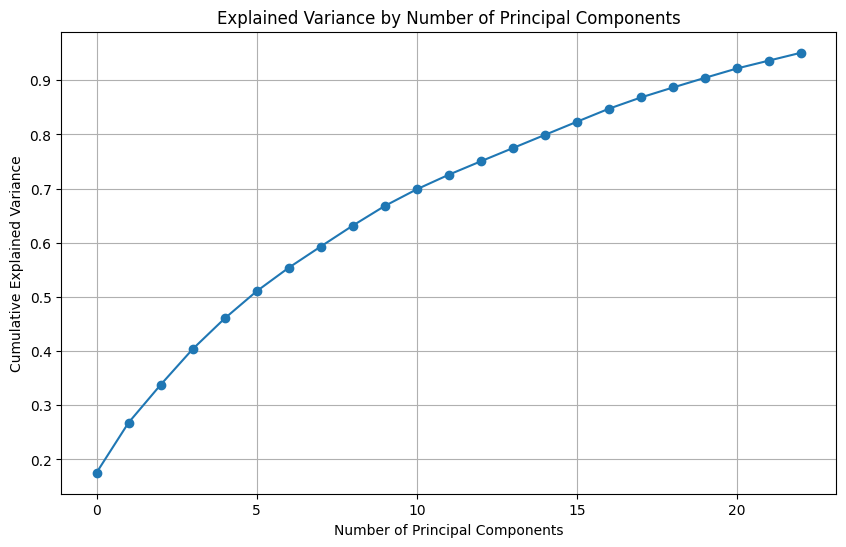

In [8]:

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

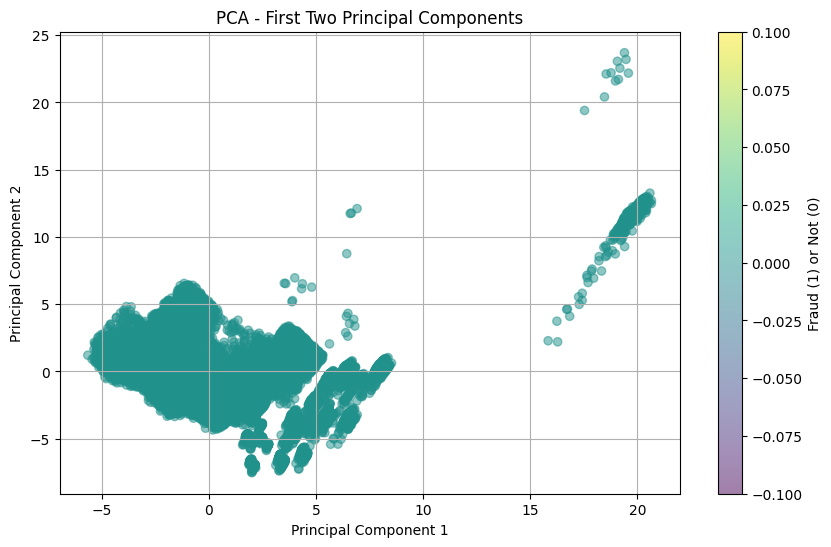

In [9]:

# Apply PCA with two components for visualization
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train)

# Plot the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.colorbar(label='Fraud (1) or Not (0)')
plt.grid(True)
plt.show()


In [12]:
# Inspect the dataframe columns to identify the correct names
print(df_cleaned.columns)

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Id', 'Customer Segment', 'Customer State',
       'Department Id', 'Department Name', 'Market', 'Order City',
       'Order Country', 'Order Customer Id', 'Order Id',
       'Order Item Cardprod Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Profit Per Order', 'Order Region',
       'Order State', 'Order Status', 'Product Card Id', 'Product Category Id',
       'Product Name', 'Product Price', 'Shipping Mode', 'Cust_Full_Name',
       'order_yr', 'order_month', 'order_day', 'order_hour'],
      dtype='object')


# Model building

In [43]:
# Initialize and train the KAN model
model = KAN(width=[X_train_pca.shape[1], 2], grid=3, k=3)

In [44]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())


image_folder = 'video_img'

results = model.train(dataset, opt="LBFGS", steps=50, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(), save_fig=True, beta=10)

print(f"Train Accuracy: {train_acc().item() * 100:.2f}%")
print(f"Test Accuracy: {test_acc().item() * 100:.2f}%")

train loss: 0.00e+00 | test loss: 0.00e+00 | reg: 1.32e+01 : 100%|██| 50/50 [28:34<00:00, 34.29s/it]


Train Accuracy: 100.00%
Test Accuracy: 100.00%


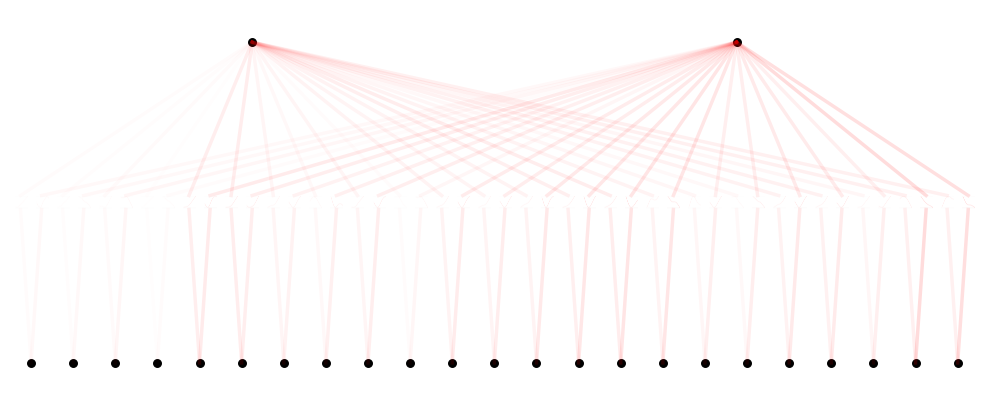

In [62]:
model.plot(beta=1, scale=1.25)

In [48]:
import os
import numpy as np
import moviepy.video.io.ImageSequenceClip # moviepy == 1.0.3


video_name='video'
fps=5

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


In [63]:
import os
import numpy as np
import moviepy.video.io.ImageSequenceClip

image_folder = 'video'  # Ensure this is correctly set
video_name = 'video'
fps = 5

files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)
image_files = [f"{image_folder}/{str(idx)}.jpg" for idx in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(f"{video_name}.mp4")


Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


In [49]:
results['train_acc'][-1], results['test_acc'][-1]

(1.0, 1.0)

In [ ]:
logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)

In [50]:
# Perform symbolic regression to generate formulas
lib = ['x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin', 'abs']
model.auto_symbolic(lib=lib)
formula1, formula2 = model.symbolic_formula()[0]


fixing (0,0,0) with sin, r2=0.9899713397026062
fixing (0,0,1) with sin, r2=0.9571999907493591
fixing (0,1,0) with tanh, r2=0.9842257499694824
fixing (0,1,1) with tanh, r2=0.9817110896110535
fixing (0,2,0) with sin, r2=0.9764384627342224
fixing (0,2,1) with sin, r2=0.9637542963027954
fixing (0,3,0) with abs, r2=0.9701467156410217
fixing (0,3,1) with tanh, r2=0.9745429158210754
fixing (0,4,0) with tanh, r2=0.9996620416641235
fixing (0,4,1) with sin, r2=0.999592661857605
fixing (0,5,0) with sin, r2=0.9995222687721252
fixing (0,5,1) with x^2, r2=0.9994004368782043
fixing (0,6,0) with tanh, r2=0.9939467310905457
fixing (0,6,1) with sin, r2=0.99921715259552
fixing (0,7,0) with sin, r2=0.9994853734970093
fixing (0,7,1) with sin, r2=0.8768020272254944
fixing (0,8,0) with sin, r2=0.999262273311615
fixing (0,8,1) with sin, r2=0.9992374181747437
fixing (0,9,0) with sin, r2=0.9997986555099487
fixing (0,9,1) with sin, r2=0.9677584171295166
fixing (0,10,0) with tanh, r2=0.9975088238716125
fixing (0,

In [51]:
formula1

-0.03*(0.7 - x_23)**2 + 0.17*exp(0.54*x_19) - 0.27*log(6.75 - 1.78*x_13) - 1.0*sin(0.15*x_1 - 4.33) + 0.2*sin(0.36*x_10 + 8.75) + 0.07*sin(1.17*x_17 + 8.57) + 0.52*sin(0.36*x_18 + 1.78) - 0.38*sin(0.7*x_22 + 5.05) - 0.78*sin(0.23*x_3 + 1.81) - 0.85*sin(0.46*x_6 - 4.15) - 0.23*sin(0.65*x_8 - 0.95) + 0.63*sin(0.41*x_9 - 7.17) + 1.12*tanh(0.33*x_11 - 1.28) + 0.68*tanh(0.42*x_12 - 1.15) + 0.92*tanh(0.41*x_14 - 0.96) + 1.04*tanh(0.34*x_15 - 0.9) + 0.06*tanh(2.4*x_16 + 3.77) + 0.31*tanh(0.26*x_2 - 0.94) + 1.33*tanh(0.34*x_20 - 1.2) + 0.8*tanh(0.44*x_21 - 0.91) + 0.63*tanh(0.53*x_5 - 1.09) + 0.51*tanh(0.45*x_7 - 1.21) + 0.01*Abs(8.15*x_4 + 6.12) + 15.06

In [52]:
formula2    

0.03*(0.22 - x_16)**3 + 0.04*(-x_6 - 0.78)**2 - 0.14*sin(0.2*x_1 - 5.01) - 0.8*sin(0.29*x_10 - 7.67) - 0.34*sin(0.84*x_11 + 8.42) - 0.42*sin(0.72*x_12 + 2.16) + 0.2*sin(1.05*x_13 + 5.22) - 0.16*sin(0.97*x_14 - 4.59) - 0.83*sin(0.37*x_15 + 7.81) + 0.41*sin(0.78*x_17 + 5.38) - 0.36*sin(0.91*x_19 - 4.04) - 0.57*sin(0.75*x_20 + 2.15) - 3.15*sin(0.3*x_21 + 1.87) - 1.0*sin(0.24*x_3 - 1.38) - 0.16*sin(0.92*x_5 + 8.36) + 0.36*sin(0.65*x_7 - 7.17) - 0.06*sin(1.29*x_8 - 3.95) + 0.26*sin(0.56*x_9 - 7.8) - 0.38*tanh(0.32*x_18 - 0.12) - 0.3*tanh(0.25*x_2 - 0.7) - 0.75*tanh(0.36*x_22 + 0.82) - 0.33*tanh(0.89*x_23 + 1.44) - 0.13*tanh(0.3*x_4 - 1.06) - 9.11

In [57]:
from sympy import lambdify

# Convert SymPy expressions to lambda functions
formula1_lambda = lambdify([f'x_{i+1}' for i in range(23)], formula1, modules=["numpy", {"exp": np.exp, "log": np.log, "sin": np.sin, "tanh": np.tanh, "abs": np.abs}])
formula2_lambda = lambdify([f'x_{i+1}' for i in range(23)], formula2, modules=["numpy", {"exp": np.exp, "log": np.log, "sin": np.sin, "tanh": np.tanh, "abs": np.abs}])

# Function to evaluate the accuracy of the formulas
def acc(formula1_lambda, formula2_lambda, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        input_values = {f'x_{j+1}': X[i, j].item() for j in range(X.shape[1])}
        logit1 = formula1_lambda(**input_values)
        logit2 = formula2_lambda(**input_values)
        correct += (logit2 > logit1) == y[i].item()
    return correct / batch

# Print train and test accuracy of the formulas
print('Train accuracy of the formula:', acc(formula1_lambda, formula2_lambda, dataset['train_input'], dataset['train_label']))
print('Test accuracy of the formula:', acc(formula1_lambda, formula2_lambda, dataset['test_input'], dataset['test_label']))

Train accuracy of the formula: 1.0
Test accuracy of the formula: 1.0


In [59]:
print("Interpretation of Formula 1:")
print(formula1)

Interpretation of Formula 1:
-0.03*(0.7 - x_23)**2 + 0.17*exp(0.54*x_19) - 0.27*log(6.75 - 1.78*x_13) - 1.0*sin(0.15*x_1 - 4.33) + 0.2*sin(0.36*x_10 + 8.75) + 0.07*sin(1.17*x_17 + 8.57) + 0.52*sin(0.36*x_18 + 1.78) - 0.38*sin(0.7*x_22 + 5.05) - 0.78*sin(0.23*x_3 + 1.81) - 0.85*sin(0.46*x_6 - 4.15) - 0.23*sin(0.65*x_8 - 0.95) + 0.63*sin(0.41*x_9 - 7.17) + 1.12*tanh(0.33*x_11 - 1.28) + 0.68*tanh(0.42*x_12 - 1.15) + 0.92*tanh(0.41*x_14 - 0.96) + 1.04*tanh(0.34*x_15 - 0.9) + 0.06*tanh(2.4*x_16 + 3.77) + 0.31*tanh(0.26*x_2 - 0.94) + 1.33*tanh(0.34*x_20 - 1.2) + 0.8*tanh(0.44*x_21 - 0.91) + 0.63*tanh(0.53*x_5 - 1.09) + 0.51*tanh(0.45*x_7 - 1.21) + 0.01*Abs(8.15*x_4 + 6.12) + 15.06


In [60]:
print("\nInterpretation of Formula 2:")
print(formula2)


Interpretation of Formula 2:
0.03*(0.22 - x_16)**3 + 0.04*(-x_6 - 0.78)**2 - 0.14*sin(0.2*x_1 - 5.01) - 0.8*sin(0.29*x_10 - 7.67) - 0.34*sin(0.84*x_11 + 8.42) - 0.42*sin(0.72*x_12 + 2.16) + 0.2*sin(1.05*x_13 + 5.22) - 0.16*sin(0.97*x_14 - 4.59) - 0.83*sin(0.37*x_15 + 7.81) + 0.41*sin(0.78*x_17 + 5.38) - 0.36*sin(0.91*x_19 - 4.04) - 0.57*sin(0.75*x_20 + 2.15) - 3.15*sin(0.3*x_21 + 1.87) - 1.0*sin(0.24*x_3 - 1.38) - 0.16*sin(0.92*x_5 + 8.36) + 0.36*sin(0.65*x_7 - 7.17) - 0.06*sin(1.29*x_8 - 3.95) + 0.26*sin(0.56*x_9 - 7.8) - 0.38*tanh(0.32*x_18 - 0.12) - 0.3*tanh(0.25*x_2 - 0.7) - 0.75*tanh(0.36*x_22 + 0.82) - 0.33*tanh(0.89*x_23 + 1.44) - 0.13*tanh(0.3*x_4 - 1.06) - 9.11


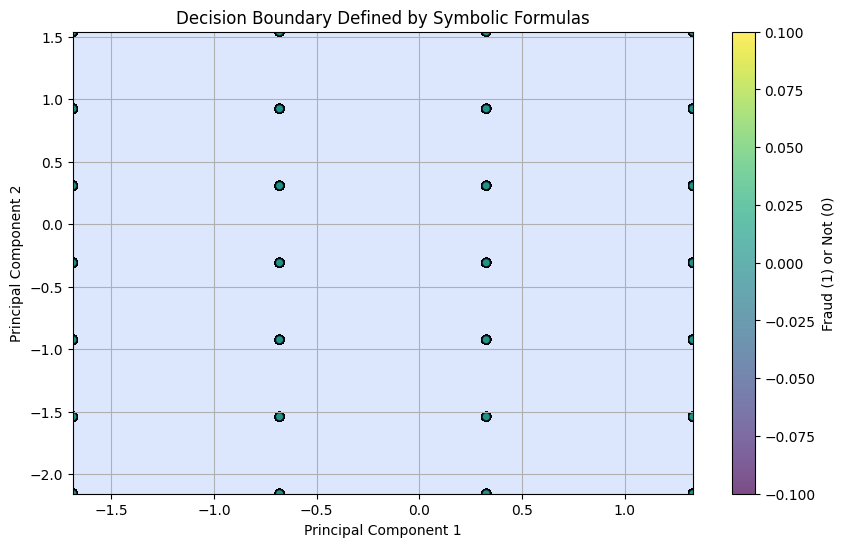

In [61]:
# Create a mesh grid for visualization
xx, yy = np.meshgrid(np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 500),
                     np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 500))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Evaluate the symbolic formulas on the grid points
grid_formula1 = np.array([formula1_lambda(x, y, *([0] * 21)) for x, y in grid_points])
grid_formula2 = np.array([formula2_lambda(x, y, *([0] * 21)) for x, y in grid_points])

# Determine the decision boundary
decision_boundary = grid_formula2 > grid_formula1

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, decision_boundary.reshape(xx.shape), alpha=0.3, cmap='coolwarm')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary Defined by Symbolic Formulas')
plt.colorbar(label='Fraud (1) or Not (0)')
plt.grid(True)
plt.show()